In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import kstest

In [2]:
df_run = pd.read_csv('fig_5.csv')
feat_train = [
'speaking_rate',
 'whisper_confidence',
 'hnr',
 'envelope',
 'f1_mean',
 'f2_mean',
 'f1_std',
 'f2_std',
 'jitter',
 'shimmer',
 'pitch_mean',
 'pitch_std',
 'cpp_1'
 ]

### Model Training

**Train-Test split - Outer Loop**

In [3]:
def train_test_split_kstest(df, N_folds, seed=0, alpha=0.1, col_group_name='outer_fold'):
    unique_users = df['user_id'].unique()
    
    any_test_passed = True
    while any_test_passed:
        np.random.seed(seed)
        np.random.shuffle(unique_users)

        if col_group_name in df.columns:
            df.drop(columns = col_group_name, inplace=True)

        df_group_assignments = pd.DataFrame({
            'user_id': unique_users,
            col_group_name: np.arange(len(unique_users)) % N_folds
        })

        df = df.merge(df_group_assignments, on='user_id', how='left')

        p_value_groups = []
        for group in range(N_folds):
            s1 = df.query(f'{col_group_name} != @group').effort_mean
            s2 = df.query(f'{col_group_name} == @group').effort_mean
            p_value_group = kstest(s1, s2).pvalue
            p_value_groups.append(p_value_group)

        p_value_groups = np.array(p_value_groups)
        any_test_passed = any(p_value_groups < alpha)
        if not any_test_passed:
            any_test_passed = False
            break
        seed += 1
    return df_group_assignments, seed

In [4]:
# train-test split for outer folds

N_folds_outer = 5
N_folds_inner = 5
df_groups = df_run[['user_id','effort_mean']].copy()
df_group_assignments, seed = train_test_split_kstest(df_groups ,N_folds_outer, seed=10, alpha=0.1, col_group_name='outer_fold')

if 'outer_fold' in df_run.columns:
    df_run.drop(columns = 'outer_fold', inplace=True)
df_run = df_run.merge(df_group_assignments, on='user_id', how='left')
print(f'Listo outer folds (seed={seed})')

df_group_assignments.rename(columns={'outer_fold':'fold'}).sort_values('fold').to_csv('5_folds.csv',index=False)

Listo outer folds (seed=40)


In [5]:
# train-test split for inner folds

for outer_fold in range(N_folds_outer):
    df_groups = df_run[['user_id','effort_mean','outer_fold']].copy()
    df_groups = df_groups.query('outer_fold!=@outer_fold')
    col_group_name = f'inner_fold_{outer_fold}'
    
    df_group_assignments,i = train_test_split_kstest(df_groups, N_folds_inner, seed=0, alpha=0.1, col_group_name=col_group_name)
    
    if col_group_name in df_run.columns:
        df_run.drop(columns = col_group_name, inplace=True)
    
    # break
    df_run = df_run.merge(df_group_assignments, on='user_id', how='left')
    print(f'Listo inner folds de outer G{outer_fold} (i={i}) ({col_group_name})')

Listo inner folds de outer G0 (i=276) (inner_fold_0)
Listo inner folds de outer G1 (i=151) (inner_fold_1)
Listo inner folds de outer G2 (i=202) (inner_fold_2)
Listo inner folds de outer G3 (i=27) (inner_fold_3)
Listo inner folds de outer G4 (i=287) (inner_fold_4)


**Model Training**

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error, r2_score

In [7]:
col_group_name = f'inner_fold_{outer_fold}'
def evaluate_by_cv(model, df_train, feat_train, N_folds_inner, col_group_name):
    df_results_cv = pd.DataFrame()
    for inner_fold in range(N_folds_inner):

        X_train_fold = df_train.query(f'{col_group_name} != @inner_fold')[feat_train]
        y_train_fold = df_train.query(f'{col_group_name} != @inner_fold')['effort_mean']
        
        X_val_fold = df_train.query(f'{col_group_name} == @inner_fold')[feat_train]
        y_val_fold = df_train.query(f'{col_group_name} == @inner_fold')['effort_mean']

        model.fit(X_train_fold, y_train_fold)

        y_val_fold_pred = model.predict(X_val_fold)

        df_results_cv.loc[0,f'rmse_val_{inner_fold}'] = mean_squared_error(y_val_fold, y_val_fold_pred, squared=False)
        
        df_results_cv.loc[0,f'r2_val_{inner_fold}'] = r2_score(y_val_fold, y_val_fold_pred)

    return df_results_cv

In [8]:
alphas = np.logspace(-3, 2, 21)
alphas = alphas[:-2]
alphas

array([1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01])

In [9]:
np.random.seed(2023)
df_results_inner = []
df_fold_predictons = pd.DataFrame()

for outer_fold in range(N_folds_outer):
    print(f'Outer fold {outer_fold}')

    df_train = df_run.query('outer_fold != @outer_fold').copy()
    df_test = df_run.query('outer_fold == @outer_fold').copy()

    for alpha in alphas:
    
        lasso_pipeline = Pipeline([
                            ('scaler', StandardScaler()),
                            ('lasso', Lasso(max_iter = 10000, alpha=alpha))
                        ])
            
        df_results_cv = evaluate_by_cv(lasso_pipeline, df_train, feat_train, N_folds_inner, col_group_name)
        df_results_cv['outer_fold'] = outer_fold
        df_results_cv['alpha'] = alpha
                
        lasso_pipeline.fit(df_train[feat_train], df_train['effort_mean'])
        y_test_pred = lasso_pipeline.predict(df_test[feat_train])

        df_results_inner.append(df_results_cv)
    print('------------------------')

df_results_inner = pd.concat(df_results_inner, ignore_index=True)


Outer fold 0


------------------------
Outer fold 1
------------------------
Outer fold 2
------------------------
Outer fold 3
------------------------
Outer fold 4
------------------------


In [10]:
df_results_inner['rmse_val_mean'] = df_results_inner[[f'rmse_val_{fold}' for fold in range(N_folds_inner)]].mean(axis=1)
df_results_inner['rmse_val_std'] = df_results_inner[[f'rmse_val_{fold}' for fold in range(N_folds_inner)]].std(axis=1)

df_results_inner['r2_val_mean'] = df_results_inner[[f'r2_val_{fold}' for fold in range(N_folds_inner)]].mean(axis=1)
df_results_inner['r2_val_std'] = df_results_inner[[f'r2_val_{fold}' for fold in range(N_folds_inner)]].std(axis=1)

Outer fold 0 - Best alpha: 0.1778279410038923
Outer fold 1 - Best alpha: 0.1
Outer fold 2 - Best alpha: 0.5623413251903491
Outer fold 3 - Best alpha: 0.05623413251903491
Outer fold 4 - Best alpha: 0.005623413251903491


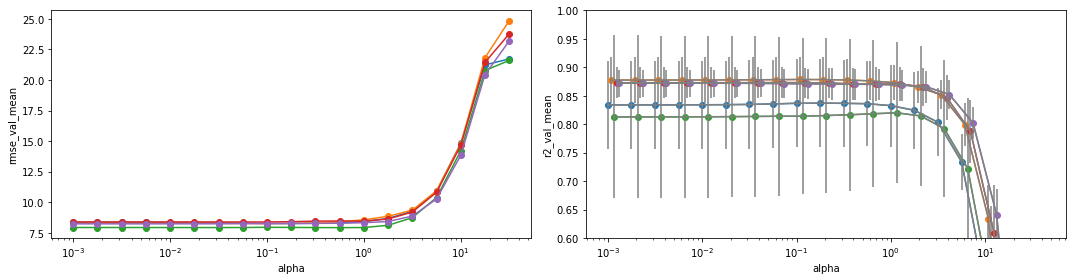

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), tight_layout=True)

alphas_selected = []
for outer_fold in range(N_folds_outer):
    df_results_outer = df_results_inner.query('outer_fold == @outer_fold')
    best_alpha = df_results_outer.loc[df_results_outer['rmse_val_mean'].idxmin(), 'alpha']
    print(f'Outer fold {outer_fold} - Best alpha: {best_alpha}')
    
    alphas_selected.append(best_alpha)
    
    axs[0].plot(df_results_outer.alpha, df_results_outer.rmse_val_mean, 'o-')
    axs[0].set_xlabel('alpha')
    axs[0].set_ylabel('rmse_val_mean')

    axs[1].plot(df_results_outer.alpha*(1+.08*outer_fold), df_results_outer.r2_val_mean, 'o-')
    axs[1].errorbar(df_results_outer.alpha*(1+.08*outer_fold), df_results_outer.r2_val_mean, df_results_outer.r2_val_std,c=[.5,0.5,0.5])
    axs[1].set_xlabel('alpha')
    axs[1].set_ylabel('r2_val_mean')
    axs[1].set_ylim(0.6,1)

for ax in axs:
    ax.set_xscale('log')

In [12]:
np.random.seed(2023)
df_results_outer = pd.DataFrame()
df_feature_weights = pd.DataFrame()
df_fold_predictions = pd.DataFrame()

for outer_fold in range(N_folds_outer):
    print(f'Outer fold {outer_fold}')
    df_train = df_run.query('outer_fold != @outer_fold').copy()
    df_test = df_run.query('outer_fold == @outer_fold').copy()

    alpha = 0.1
    lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter = 10000, alpha=alpha))])
        
    lasso_pipeline.fit(df_train[feat_train], df_train['effort_mean'])
    
    y_test_pred = lasso_pipeline.predict(df_test[feat_train])
    df_fold_predictions = pd.concat((df_fold_predictions,
                            pd.DataFrame({'observed':df_test['effort_mean'].values,
                                          'predicted':y_test_pred,
                                          'outer_fold':np.repeat(outer_fold,len(y_test_pred))}))).reset_index(drop=True)

    df_results_outer.loc[outer_fold, f'rmse_val'] = mean_squared_error(df_test['effort_mean'], y_test_pred, squared=False)
    df_results_outer.loc[outer_fold, f'r2_val'] = r2_score(df_test['effort_mean'], y_test_pred)
    df_feature_weights[f'outer_fold_{outer_fold}'] = lasso_pipeline.named_steps['lasso'].coef_


    print('------------------------')
df_feature_weights.index = feat_train

Outer fold 0
------------------------
Outer fold 1
------------------------
Outer fold 2
------------------------
Outer fold 3
------------------------
Outer fold 4
------------------------


In [13]:
df_results_outer.r2_val.mean(), df_results_outer.r2_val.std()

(0.8326910426918781, 0.07005122356975968)

In [14]:
df_results_outer.rmse_val.mean(), df_results_outer.rmse_val.std()

(8.556713334281923, 0.6044891139067493)

In [15]:
# R2 p-val

all_y_test = []
all_y_pred = []
for outer_fold in range(N_folds_outer):
    print(f'Outer fold {outer_fold}')
    df_train = df_run.query('outer_fold != @outer_fold').copy()
    df_test = df_run.query('outer_fold == @outer_fold').copy()

    alpha = 0.1
    lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter = 10000, alpha=alpha))])
        
    lasso_pipeline.fit(df_train[feat_train], df_train['effort_mean'])
    
    y_test_pred = lasso_pipeline.predict(df_test[feat_train])

    all_y_test.extend(df_test['effort_mean'].values)
    all_y_pred.extend(y_test_pred)


    print('------------------------')

from sklearn.metrics import r2_score
from scipy.stats import f
# Calculate R^2
r2 = r2_score(all_y_test, all_y_pred)

# Parameters for F-statistic
n = len(all_y_test)  # Number of data points
k = len(feat_train)  # Number of predictors

# Calculate F-statistic
F = (r2 / k) / ((1 - r2) / (n - k - 1))

# Calculate p-value
p_value = 1 - f.cdf(F, dfn=k, dfd=n - k - 1)

print(f"F-statistic: {F}")
print(f"P-value: {p_value}")

Outer fold 0
------------------------
Outer fold 1
------------------------
Outer fold 2
------------------------
Outer fold 3
------------------------
Outer fold 4
------------------------
F-statistic: 292.2095019489602
P-value: 1.1102230246251565e-16


##### Figure for paper

oldpos: [0.125, 0.125, 0.775, 0.755]
newpos: [0.125   0.      0.79825 1.     ]


<Figure size 432x288 with 0 Axes>

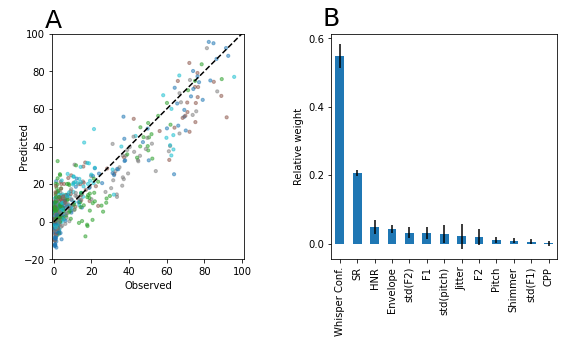

In [16]:
plt.set_cmap("tab10") 

fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(8, 4))
gridspec = axs[1].get_subplotspec().get_gridspec()

# clear the left column for the subfigure:
axs[1].remove()

np.random.seed(seed=1)
df_fold_predictions = df_fold_predictions.iloc[np.random.permutation(len(df_fold_predictions))] # Para que no queden todos los del ultimo fold arriba
axs[0].scatter(df_fold_predictions.observed,df_fold_predictions.predicted,c=df_fold_predictions.outer_fold,alpha=0.5,s=10)
axs[0].set_xlabel('Observed')
axs[0].set_ylabel('Predicted')
axs[0].set_ylim(-20, 100)
axs[0].set_xlim(-1, 101)
axs[0].plot([0,100], [0,100], color='black', linestyle='--')
axs[0].set_aspect('equal')
axs[0].yaxis.set_label_coords(-0.12,0.5)
axs[0].text(x=-.5,y=axs[0].get_ylim()[1]*1.07,va='center',ha='center',s='A',fontsize=25)    

# make the subfigure in the empty gridspec slots:
subfig = fig.add_subfigure(gridspec[1])
axsLeft = subfig.subplots(1, 1)


df_plot = pd.DataFrame([df_feature_weights.mean(axis=1), df_feature_weights.std(axis=1)]).T
df_plot.columns = ['mean','std']
df_plot['feature'] = df_plot.index
df_plot['mean'] = np.abs(df_plot['mean'])
norm = np.sum(df_plot['mean'])
df_plot['std'] = df_plot['std']/norm
df_plot['mean'] = df_plot['mean']/norm
df_plot = df_plot.sort_values('mean',ascending=False)
newnames = {'whisper_confidence':'Whisper Conf.','speaking_rate':'SR','envelope':'Envelope','hnr':'HNR','f2_std':'std(F2)',
         'pitch_std':'std(pitch)','f1_mean':'F1','f2_mean':'F2','pitch_mean':'Pitch','jitter':'Jitter','shimmer':'Shimmer','f1_std':'std(F1)','cpp_1':'CPP'}
for val in newnames:
    df_plot['feature'] = df_plot['feature'].str.replace(val,newnames[val])

df_plot.plot.bar(ax=axsLeft,x='feature', y='mean', yerr='std',legend=False)
axsLeft.set_yticks(ticks=[0,0.2,0.4,0.6])   
axsLeft.set_xlabel('')
axsLeft.set_ylabel('Relative weight')


axsLeft.text(x=-.5,y=axsLeft.get_ylim()[1]*1.07,va='center',ha='center',s='B',fontsize=25)
pos1 = axsLeft.get_position()
print('oldpos:',[pos1.x0, pos1.y0,  pos1.width, pos1.height])
pos2 = [pos1.x0, pos1.y0,  pos1.width, pos1.height] 
pos2 = [pos1.x0 , pos1.y0 - .125,  pos1.width*1.03, pos1.height + .245] 
print('newpos:',np.round(pos2,5))
axsLeft.set_position(pos2) 
plt.show()